## Imports

In [13]:
from pathlib import Path
from river import preprocessing, tree, datasets
from river.evaluate import Track
from river.metrics import Accuracy, MSE
from torch import nn, optim
from IncrementalDL.OnlineTorch.classifier import RollingPyTorch2RiverClassifer
from IncrementalDL.OnlineTorch.nn_functions.regression import build_torch_mlp_regressor, build_torch_lstm_regressor
from IncrementalDL.OnlineTorch.regressor import PyTorch2RiverRegressor
from IncrementalDL.config import CLASSIFICATION_TRACKS, N_SAMPLES, N_CHECKPOINTS
from IncrementalDL.utils import plot_track
from river import compose


In [16]:
# Show Track
dataset = datasets.Taxis().take(20)

for d in dataset:
    print(d)


({'vendor_id': '2', 'pickup_datetime': datetime.datetime(2016, 1, 1, 0, 0, 17), 'passenger_count': 5, 'pickup_longitude': -73.98174285888672, 'pickup_latitude': 40.71915817260742, 'dropoff_longitude': -73.93882751464845, 'dropoff_latitude': 40.82918167114258, 'store_and_fwd_flag': 'N'}, 849)
({'vendor_id': '1', 'pickup_datetime': datetime.datetime(2016, 1, 1, 0, 0, 53), 'passenger_count': 1, 'pickup_longitude': -73.98508453369139, 'pickup_latitude': 40.74716567993164, 'dropoff_longitude': -73.95803833007811, 'dropoff_latitude': 40.71749114990234, 'store_and_fwd_flag': 'N'}, 1294)
({'vendor_id': '2', 'pickup_datetime': datetime.datetime(2016, 1, 1, 0, 1, 1), 'passenger_count': 5, 'pickup_longitude': -73.9652786254883, 'pickup_latitude': 40.80104064941406, 'dropoff_longitude': -73.94747924804686, 'dropoff_latitude': 40.81517028808594, 'store_and_fwd_flag': 'N'}, 408)
({'vendor_id': '1', 'pickup_datetime': datetime.datetime(2016, 1, 1, 0, 1, 14), 'passenger_count': 1, 'pickup_longitude': 

In [8]:
track_name = 'test'
n_samples = 10_000

def track_fn(n_samples = n_samples, seed):
    dataset = datasets.Bikes().take(n_samples)
    metric = MSE()
    track = Track(track_name, dataset, metric, n_samples)
    return track

TypeError: track_fn() got an unexpected keyword argument 'seed'

<Figure size 432x288 with 0 Axes>

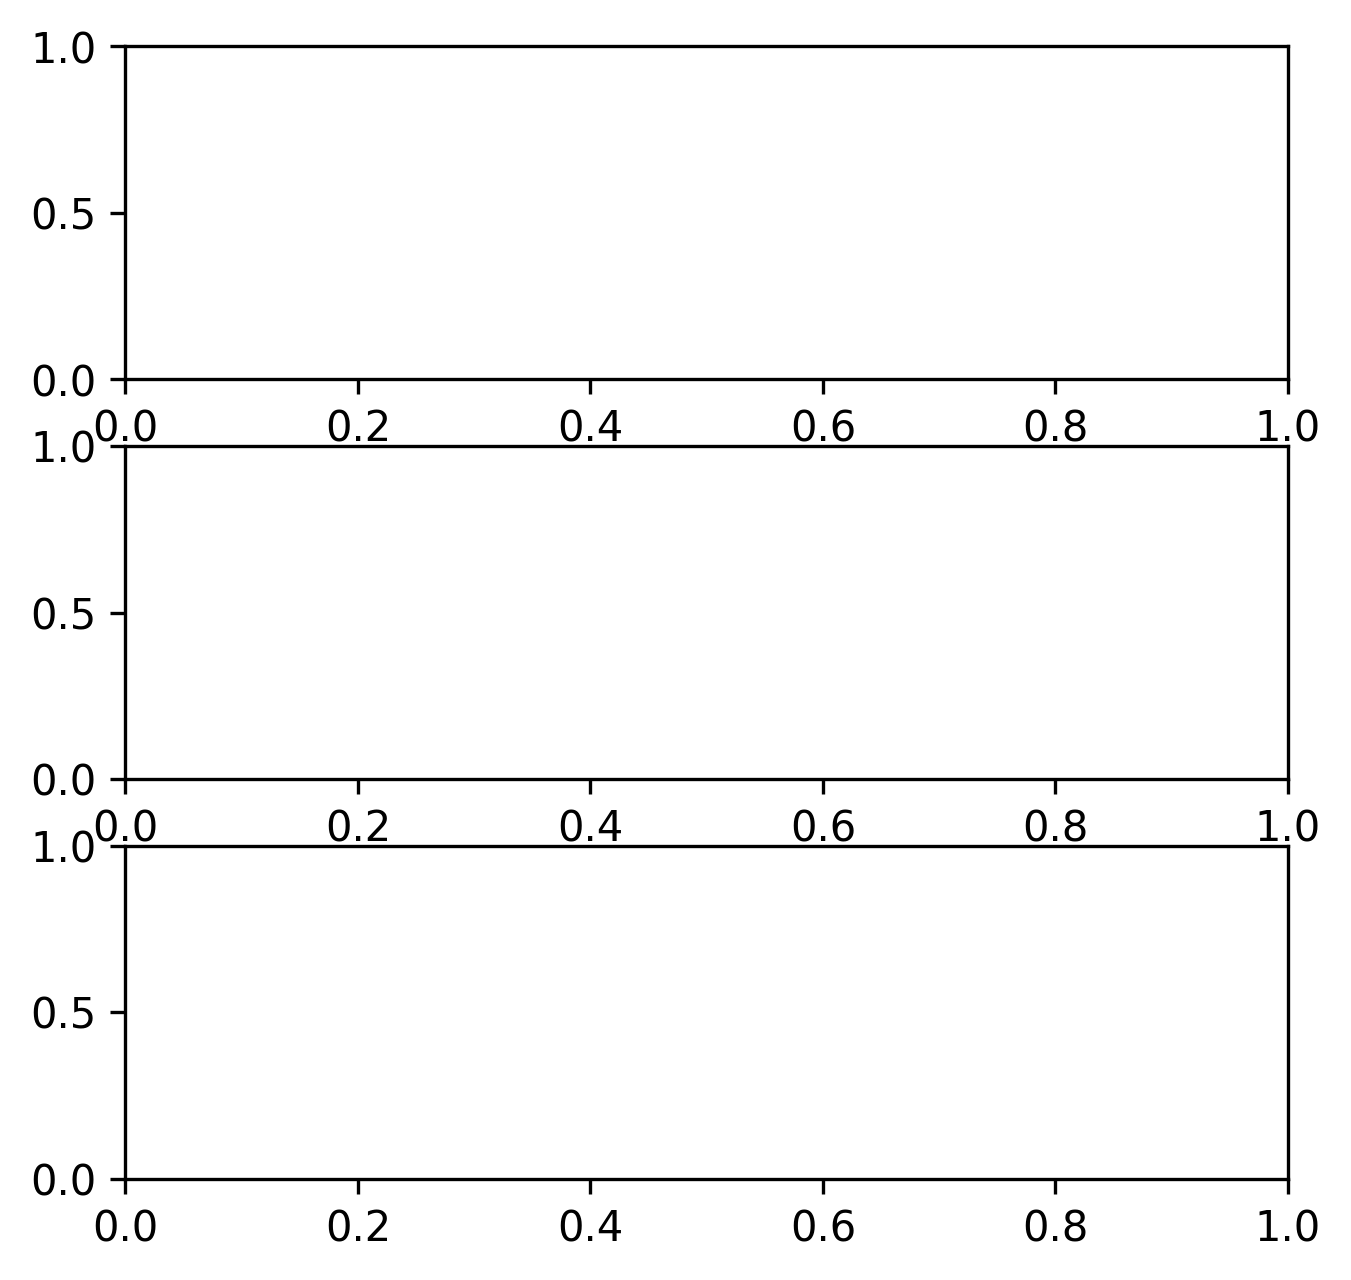

In [10]:
plot_track(
        track=track_fn,
        metric_name="Accuracy",
        models={
            'Torch LSTM Regressor': (
                    compose.Select('clouds', 'humidity', 'pressure', 'temperature', 'wind')
                    | preprocessing.StandardScaler()
                    | RollingPyTorch2RiverClassifer(
                        build_fn=build_torch_lstm_regressor,
                        loss_fn=nn.BCELoss,
                        optimizer_fn=optim.Adam,
                        window_size=20,
                        learning_rate=1e-3,
                        hidden_size = 2,
                        num_layers = 1,

                    )),
            'Torch MLP Regressor': (
                compose.Select('clouds', 'humidity', 'pressure', 'temperature', 'wind')
                | preprocessing.StandardScaler()
                | PyTorch2RiverRegressor(
                    build_fn=build_torch_mlp_regressor,
                    loss_fn=nn.BCELoss,
                    optimizer_fn=optim.Adam,
                    batch_size=1,
                    learning_rate=1e-3,
                )),
            'HTC': (
                compose.Select('clouds', 'humidity', 'pressure', 'temperature', 'wind')
                | preprocessing.StandardScaler()
                | tree.HoeffdingTreeClassifier()),
        },
        n_samples=N_SAMPLES,
        n_checkpoints=N_CHECKPOINTS,
        result_path=Path(f'./results/classification/example_classification/{track_name}'),
        verbose=2
    )